In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import animation
import PIL
from PIL import Image
import numpy as np
#from osgeo import gdal
import sklearn.preprocessing as sk
#from __future__ import division
import PIL
import cv2
from numpy.linalg import inv
import os
import random
from fractal_generator import *

## Triangulation optimize test

In [163]:
def apply_affine_transform(src, src_tri, target_tri, size):
    warp_mat = cv2.getAffineTransform(np.float32(src_tri), np.float32(target_tri))
    dst = cv2.warpAffine(src, warp_mat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_REFLECT_101)
    return dst


def morph_triangle(img1, img2, img, t1, t2, t, alpha):
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    r = cv2.boundingRect(np.float32([t]))
    #print(r)
    t1_rect = []
    t2_rect = []
    t_rect = []

    for i in range(3):
        t_rect.append(((t[i][0] - r[0]), (t[i][1] - r[1])))
        t1_rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
        t2_rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
    #mask = np.zeros((r[3], r[2], 3), dtype=np.float32)
    mask = np.zeros((r[3], r[2]), dtype=np.float32)
    #print(plt.imshow(mask))
    cv2.fillConvexPoly(mask, np.int32(t_rect), (1.0, 1.0, 1.0), 16, 0)

    img1_rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2_rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]
    size = (r[2], r[3])

    warp_image1 = apply_affine_transform(img1_rect, t1_rect, t_rect, size)
    #print(warp_image1)
    warp_image2 = apply_affine_transform(img2_rect, t2_rect, t_rect, size)
    img_rect = (1.0 - alpha) * warp_image1 + alpha * warp_image2
    #print(plt.imshow(warp_image1))
    #print(0*(1 - mask) + img_rect * mask)
    img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * (1 - mask) + img_rect * mask
    return img

def get_morph(del_triangles, src_img, src_points, target_img, target_points, alpha = 0.5):

    weighted_pts = []
    for i in range(len(src_points)):
        x = (1 - alpha) * src_points[i][0] + alpha * target_points[i][0]
        y = (1 - alpha) * src_points[i][1] + alpha * target_points[i][1]
        weighted_pts.append((x, y))
    img_morph = np.zeros(src_img.shape, dtype=src_img.dtype)
    
    img_stack = []
    for triangle in del_triangles:
        x, y, z = triangle
        t1 = [src_points[x], src_points[y], src_points[z]]
        #print(t1)
        t2 = [target_points[x], target_points[y], target_points[z]]
        #print(t2)
        t = [weighted_pts[x], weighted_pts[y], weighted_pts[z]]
        #print(t)
        img_stack.append(morph_triangle(src_img, target_img, img_morph, t1, t2, t, alpha))
    return img_stack

In [195]:
pers1 = 0.4
pers2 = 0.6
im_in = fractal_generator(pers1, 1024)
#im_in = contrast(im_in)
im_in = (im_in - np.min(im_in))/np.ptp(im_in)
#im_in = im_out
#im_in = np.repeat(im_in[:, :, np.newaxis], 3, axis=2)
im_out = fractal_generator(pers2, 1024)
#im_out = contrast(im_out)
im_out = (im_out - np.min(im_out))/np.ptp(im_out)
#im_out = np.repeat(im_out[:, :, np.newaxis], 3, axis=2)
#src_points = [(0, 0), (0, 1023), (1023, 0), (1023, 1023), (445, 330), (120, 150), (750, 900), (100, 200), (200, 300), (850, 900)]
#target_points = [(0, 0), (0, 1023), (1023, 0), (1023, 1023), (645, 430), (420, 450), (950, 700), (250, 300), (350, 450), (150, 500)]
src_points = [(0, 0), (0, 1023), (1023, 0), (1023, 1023), (745, 230), (320, 650)]
target_points = [(0, 0), (0, 1023), (1023, 0), (1023, 1023), (345, 330), (220, 150)]
avg_points = []
for i in range(len(src_points)):
    x = 0.5 * src_points[i][0] + 0.5 * target_points[i][0]
    y = 0.5 * src_points[i][1] + 0.5 * target_points[i][1]
    avg_points.append((int(x), int(y)))
triangles= measure_triangle(im_in, avg_points)


(0, 0)
(0, 1023)
(1023, 0)
(1023, 1023)
(545, 280)
(270, 400)


In [196]:
dpi = 150
#del_morph = []
del_morph_clean = []
import time
start = time.time()
for percent in np.linspace(0, 1, num=100): 
    del_morph.append(get_morph(triangles, im_in, src_points, im_out, target_points, alpha=percent))
    
stop = time.time()
print(stop-start)
duration = stop-start
for i in range(len(del_morph)):
    del_morph_clean.append(contrast(del_morph[i][0]))
    im = cv2.normalize(del_morph_clean[i], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    im = Image.fromarray(im).convert('L')
    #im.show()
         
    im.save("Morphing/frac_morph{}-{}-{}.png".format(pers1, pers2, i), dpi=(dpi, dpi))

17.669525146484375


## Triangulation

In [5]:


def rect_contains(rect, point) :
        if point[0] < rect[0] :
            return False
        elif point[1] < rect[1] :
            return False
        elif point[0] > rect[2] :
            return False
        elif point[1] > rect[3] :
            return False
        return True
    
def measure_triangle(image, points):
    rect = (0, 0, image.shape[1], image.shape[0])
    sub_div = cv2.Subdiv2D(rect)

    for p in points:
        print(p)
        sub_div.insert(p)

    triangle_list = sub_div.getTriangleList()

    triangle = []
    pt = []

    for t in triangle_list:
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))

        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        if rect_contains(rect, pt1) and rect_contains(rect, pt2) and rect_contains(rect, pt3):
            ind = []
            for j in range(0, 3):
                for k in range(0, len(points)):
                    if abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0:
                        ind.append(k)
            if len(ind) == 3:
                triangle.append((ind[0], ind[1], ind[2]))

        pt = []

    return triangle

from delaunay_div_conq import *

def apply_affine_transform(src, src_tri, target_tri, size):
    warp_mat = cv2.getAffineTransform(np.float32(src_tri), np.float32(target_tri))
    dst = cv2.warpAffine(src, warp_mat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_REFLECT_101)
    return dst


def morph_triangle(img1, img2, img, t1, t2, t, alpha):
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    r = cv2.boundingRect(np.float32([t]))
    #print(r)
    t1_rect = []
    t2_rect = []
    t_rect = []

    for i in range(3):
        t_rect.append(((t[i][0] - r[0]), (t[i][1] - r[1])))
        t1_rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
        t2_rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
    mask = np.zeros((r[3], r[2], 3), dtype=np.float32)
    #mask = np.zeros((r[3], r[2]), dtype=np.float32)
    #print(plt.imshow(mask))
    cv2.fillConvexPoly(mask, np.int32(t_rect), (1.0, 1.0, 1.0), 16, 0)

    img1_rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2_rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]
    size = (r[2], r[3])

    warp_image1 = apply_affine_transform(img1_rect, t1_rect, t_rect, size)
    #print(warp_image1)
    warp_image2 = apply_affine_transform(img2_rect, t2_rect, t_rect, size)
    img_rect = (1.0 - alpha) * warp_image1 + alpha * warp_image2
    #print(plt.imshow(warp_image1))
    #print(0*(1 - mask) + img_rect * mask)
    img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * (1 - mask) + img_rect * mask
    return img

def get_morph(del_triangles, src_img, src_points, target_img, target_points, alpha = 0.5):

    weighted_pts = []
    for i in range(len(src_points)):
        x = (1 - alpha) * src_points[i][0] + alpha * target_points[i][0]
        y = (1 - alpha) * src_points[i][1] + alpha * target_points[i][1]
        weighted_pts.append((x, y))
    img_morph = np.zeros(src_img.shape, dtype=src_img.dtype)
    
    img_stack = []
    for triangle in del_triangles:
        x, y, z = triangle
        t1 = [src_points[x], src_points[y], src_points[z]]
        #print(t1)
        t2 = [target_points[x], target_points[y], target_points[z]]
        #print(t2)
        t = [weighted_pts[x], weighted_pts[y], weighted_pts[z]]
        #print(t)
        img_stack.append(morph_triangle(src_img, target_img, img_morph, t1, t2, t, alpha))
    return img_stack
    #return cv2.cvtColor(np.uint8(img_morph), cv2.COLOR_RGB2BGR)

In [157]:
import time
pers1 = 0.6
pers2 = 0.8
im_in = fractal_generator(pers1, 1024)
#im_in = contrast(im_in)
im_in = (im_in - np.min(im_in))/np.ptp(im_in)
im_in = np.repeat(im_in[:, :, np.newaxis], 3, axis=2)
im_out = fractal_generator(pers2, 1024)
#im_out = contrast(im_out)
im_out = (im_out - np.min(im_out))/np.ptp(im_out)
im_out = np.repeat(im_out[:, :, np.newaxis], 3, axis=2)
#src_points = [(0, 0), (0, 511), (511, 0), (511, 511), (245, 130), (120, 150), (80, 23), (235, 345), (444, 333), (356, 234), (50, 222)]
#target_points = [(0, 0), (0, 511), (511, 0), (511, 511), (345, 230), (220, 250), (180, 123), (335, 445), (444, 333), (356, 234), (50, 222) ]
src_points = [(0, 0), (0, 1023), (1023, 0), (1023, 1023), (445, 330), (120, 150)]
target_points = [(0, 0), (0, 1023), (1023, 0), (1023, 1023), (645, 430), (420, 450)]
avg_points = []
for i in range(len(src_points)):
    x = 0.5 * src_points[i][0] + 0.5 * target_points[i][0]
    y = 0.5 * src_points[i][1] + 0.5 * target_points[i][1]
    avg_points.append((int(x), int(y)))

start = time.time()
triangles= measure_triangle(im_in, avg_points)
stop = time.time()
duration = (stop-start)

#(0, 0), (0, 511), (511, 0), (511, 511)


(0, 0)
(0, 1023)
(1023, 0)
(1023, 1023)
(545, 380)
(270, 300)


In [156]:
dpi = 150
del_morph = []
del_morph_clean = []
import time
for percent in np.linspace(1, 0, num=20):
    start = time.time()
    del_morph.append(get_morph(triangles, im_in, src_points, im_out, target_points, alpha=percent))
    stop = time.time()
    print(stop-start)
duration = stop-start
for i in range(len(del_morph)):
    del_morph_clean.append(contrast(del_morph[i][0][:, :, 0]))
    im = cv2.normalize(del_morph_clean[i], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    im = Image.fromarray(im).convert('L')
    #im.show()
         
    im.save("Morphing/frac_morph{}-{}-{}.png".format(pers1, pers2, i), dpi=(dpi, dpi))

0.3990006446838379
0.3959939479827881
0.3840024471282959
0.3769998550415039
0.3730020523071289
0.37125062942504883
0.3840007781982422
0.38000059127807617
0.39200258255004883
0.3920021057128906
0.39099693298339844
0.36800289154052734
0.4049966335296631
0.37424778938293457
0.40200352668762207
0.40500593185424805
0.3569931983947754
0.40599822998046875
0.34932589530944824
0.37299585342407227


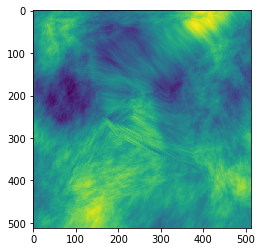

In [118]:
plt.imshow((del_morph_clean[10]))

In [43]:
def contrast(image):
    for i in range(len(image)):
        for j in range(len(image)):
            if image[i][j] >= 0.5:
                image[i][j] = 1
            elif image[i][j] < 0.5:
                image[i][j] = 0
    return image

In [169]:
#from vid_lib import Video
#video = Video('fractal_morph.avi', 20, 600, 800)
#for percent in np.linspace(1, 0, num=200):
#    print ('Writing Frame', 200 - int(percent*200) + 1)
#    video.write(get_morph(alpha=percent))

## Delaunay option2

In [ ]:
def transform(src_img, src_points, dst_img, dst_points): 
    """Transforms source image to target image, overwriting the target image.
    """
    for indices in get_triangulation_indices(src_points):
        # Get triangles from indices
        src_triangle = src_points[indices]
        dst_triangle = dst_points[indices]

        # Crop to triangle, to make calculations more efficient
        src_triangle_cropped, src_img_cropped = crop_to_triangle(src_img, src_triangle)
        dst_triangle_cropped, dst_img_cropped = crop_to_triangle(dst_img, dst_triangle)

        # Calculate transfrom to warp from old image to new
        transform = cv2.getAffineTransform(np.float32(src_triangle_cropped), np.float32(dst_triangle_cropped))

        # Warp image
        dst_img_warped = cv2.warpAffine(src_img_cropped, transform, (dst_img_cropped.shape[1], dst_img_cropped.shape[0]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

        # Create mask for the triangle we want to transform
        mask = np.zeros(dst_img_cropped.shape, dtype = np.uint8)
        cv2.fillConvexPoly(mask, np.int32(dst_triangle_cropped), (1.0, 1.0, 1.0), 16, 0);

        # Delete all existing pixels at given mask
        dst_img_cropped*=1-mask
        # Add new pixels to masked area
        dst_img_cropped+=dst_img_warped*mask

In [6]:
import cv2
import numpy as np

def get_triangulation_indices(points):
    """Get indices triples for every triangle
    """
    # Bounding rectangle
    bounding_rect = (*points.min(axis=0), *points.max(axis=0))

    # Triangulate all points
    subdiv = cv2.Subdiv2D(bounding_rect)
    subdiv.insert(list(points))

    # Iterate over all triangles
    for x1, y1, x2, y2, x3, y3 in subdiv.getTriangleList():
        # Get index of all points
        yield [(points==point).all(axis=1).nonzero()[0][0] for point in [(x1,y1), (x2,y2), (x3,y3)]]

def crop_to_triangle(img, triangle):
    """Crop image to triangle
    """
    # Get bounding rectangle
    bounding_rect = cv2.boundingRect(triangle)

    # Crop image to bounding box
    img_cropped = img[bounding_rect[1]:bounding_rect[1] + bounding_rect[3],
                      bounding_rect[0]:bounding_rect[0] + bounding_rect[2]]
    # Move triangle to coordinates in cropped image
    triangle_cropped = [(point[0]-bounding_rect[0], point[1]-bounding_rect[1]) for point in triangle]
    return triangle_cropped, img_cropped

def transform(src_img, src_points, dst_img, dst_points): 
    """Transforms source image to target image, overwriting the target image.
    """
    for indices in get_triangulation_indices(src_points):
        # Get triangles from indices
        src_triangle = src_points[indices]
        dst_triangle = dst_points[indices]

        # Crop to triangle, to make calculations more efficient
        src_triangle_cropped, src_img_cropped = crop_to_triangle(src_img, src_triangle)
        dst_triangle_cropped, dst_img_cropped = crop_to_triangle(dst_img, dst_triangle)

        # Calculate transfrom to warp from old image to new
        transform = cv2.getAffineTransform(np.float32(src_triangle_cropped), np.float32(dst_triangle_cropped))

        # Warp image
        dst_img_warped = cv2.warpAffine(src_img_cropped, transform, (dst_img_cropped.shape[1], dst_img_cropped.shape[0]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

        # Create mask for the triangle we want to transform
        mask = np.zeros(dst_img_cropped.shape, dtype = np.uint8)
        cv2.fillConvexPoly(mask, np.int32(dst_triangle_cropped), (1.0, 1.0, 1.0), 16, 0);

        # Delete all existing pixels at given mask
        dst_img_cropped*=1-mask
        # Add new pixels to masked area
        dst_img_cropped+=dst_img_warped*mask

## Python 2 

In [ ]:
### Looks in Python 2

img = cv2.imread('frac1.jpeg')

size = img.shape

rect = (0, 0, size[1], size[0])

subdiv  = cv2.Subdiv2D(rect);

# Check if a point is inside a rectangle
def rect_contains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

# Draw a point
def draw_point(img, p, color ) :
    cv2.circle( img, p, 2, color, cv2.LINE_AA)


# Draw delaunay triangles
def draw_delaunay(img, subdiv, delaunay_color ) :

    triangleList = subdiv.getTriangleList();
    size = img.shape
    r = (0, 0, size[1], size[0])

    for t in triangleList :
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        
        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
        
            cv2.line(img, pt1, pt2, delaunay_color, 1, cv2.LINE_AA, 0)
            cv2.line(img, pt2, pt3, delaunay_color, 1, cv2.LINE_AA, 0)
            cv2.line(img, pt3, pt1, delaunay_color, 1, cv2.LINE_AA, 0)


# Draw voronoi diagram
def draw_voronoi(img, subdiv) :

    ( facets, centers) = subdiv.getVoronoiFacetList([])

    for i in range(0,len(facets)) :
        ifacet_arr = []
        for f in facets[i] :
            ifacet_arr.append(f)
        
        ifacet = np.array(ifacet_arr, np.int)
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

        cv2.fillConvexPoly(img, ifacet, color, cv2.LINE_AA, 0);
        ifacets = np.array([ifacet])
        cv2.polylines(img, ifacets, True, (0, 0, 0), 1, cv2.LINE_AA, 0)
        cv2.circle(img, (centers[i][0], centers[i][1]), 3, (0, 0, 0), cv2.LINE_AA)




# Define window names
win_delaunay = "Delaunay Triangulation"
win_voronoi = "Voronoi Diagram"

# Turn on animation while drawing triangles
animate = True

# Define colors for drawing.
delaunay_color = (255,255,255)
points_color = (0, 0, 255)

# Read in the image.
img = cv2.imread("frac2.jpeg");

# Keep a copy around
img_orig = img.copy();

# Rectangle to be used with Subdiv2D
size = img.shape
rect = (0, 0, size[1], size[0])

# Create an instance of Subdiv2D
subdiv = cv2.Subdiv2D(rect);

# Create an array of points.
points = [];

# Read in the points from a text file
with open("points.txt") as file :
    for line in file :
        x, y = line.split()
        points.append((int(x), int(y)))

# Insert points into subdiv
for p in points :
    subdiv.insert(p)

    # Show animation
    if animate :
        img_copy = img_orig.copy()
        # Draw delaunay triangles
        draw_delaunay( img_copy, subdiv, (255, 255, 255) );
        cv2.imshow(win_delaunay, img_copy)
        cv2.waitKey(100)

# Draw delaunay triangles
draw_delaunay( img, subdiv, (255, 255, 255) );

# Draw points
for p in points :
    draw_point(img, p, (0,0,255))

# Allocate space for Voronoi Diagram
img_voronoi = np.zeros(img.shape, dtype = img.dtype)

# Draw Voronoi diagram
draw_voronoi(img_voronoi,subdiv)

# Show results
cv2.imshow(win_delaunay,img)
cv2.imshow(win_voronoi,img_voronoi)
cv2.waitKey(0)

In [ ]:
## PYTHON 2 AGAIN

# Kuriakose Sony Theakanath
# Face Morphing

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
from PIL import Image
from scipy import misc
import argparse
from pylab import arange, plot, sin, ginput, show
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
import cv2


def writeGif(filename, images, duration=0.1, repeat=True, dither=False,
                nq=0, subRectangles=True, dispose=None):
    """ writeGif(filename, images, duration=0.1, repeat=True, dither=False,
                    nq=0, subRectangles=True, dispose=None)

    Write an animated gif from the specified images.

    Parameters
    ----------
    filename : string
        The name of the file to write the image to.
    images : list
        Should be a list consisting of PIL images or numpy arrays.
        The latter should be between 0 and 255 for integer types, and
        between 0 and 1 for float types.
    duration : scalar or list of scalars
        The duration for all frames, or (if a list) for each frame.
    repeat : bool or integer
        The amount of loops. If True, loops infinitetely.
    dither : bool
        Whether to apply dithering
    nq : integer
        If nonzero, applies the NeuQuant quantization algorithm to create
        the color palette. This algorithm is superior, but slower than
        the standard PIL algorithm. The value of nq is the quality
        parameter. 1 represents the best quality. 10 is in general a
        good tradeoff between quality and speed. When using this option,
        better results are usually obtained when subRectangles is False.
    subRectangles : False, True, or a list of 2-element tuples
        Whether to use sub-rectangles. If True, the minimal rectangle that
        is required to update each frame is automatically detected. This
        can give significant reductions in file size, particularly if only
        a part of the image changes. One can also give a list of x-y
        coordinates if you want to do the cropping yourself. The default
        is True.
    dispose : int
        How to dispose each frame. 1 means that each frame is to be left
        in place. 2 means the background color should be restored after
        each frame. 3 means the decoder should restore the previous frame.
        If subRectangles==False, the default is 2, otherwise it is 1.

    """

    # Check PIL
    if PIL is None:
        raise RuntimeError("Need PIL to write animated gif files.")

    # Check images
    images = checkImages(images)

    # Instantiate writer object
    gifWriter = GifWriter()

    # Check loops
    if repeat is False:
        loops = 1
    elif repeat is True:
        loops = 0 # zero means infinite
    else:
        loops = int(repeat)

    # Check duration
    if hasattr(duration, '__len__'):
        if len(duration) == len(images):
            duration = [d for d in duration]
        else:
            raise ValueError("len(duration) doesn't match amount of images.")
    else:
        duration = [duration for im in images]

    # Check subrectangles
    if subRectangles:
        images, xy = gifWriter.handleSubRectangles(images, subRectangles)
        defaultDispose = 1 # Leave image in place
    else:
        # Normal mode
        xy = [(0,0) for im in images]
        defaultDispose = 2 # Restore to background color.

    # Check dispose
    if dispose is None:
        dispose = defaultDispose
    if hasattr(dispose, '__len__'):
        if len(dispose) != len(images):
            raise ValueError("len(xy) doesn't match amount of images.")
    else:
        dispose = [dispose for im in images]


    # Make images in a format that we can write easy
    images = gifWriter.convertImagesToPIL(images, dither, nq)

    # Write
    fp = open(filename, 'wb')
    try:
        gifWriter.writeGifToFile(fp, images, duration, loops, xy, dispose)
    finally:
        fp.close()

RATIO = 0.047619047619047616 # total of 20 frames
TOTAL_FEATURE = 4 # 66 total feature points
#TRIANGLES = [[20,21,23],[21,22,23],[0,1,36],[15,16,45],[0,17,36],[16,26,45],[17,18,37],[25,26,44],[17,36,37],[26,44,45],[18,19,38],[24,25,43],[18,37,38],[25,43,44],[19,20,38],[23,24,43],[20,21,39],[22,23,42],[20,38,39],[23,42,43],[21,22,27],[21,27,39],[22,27,42],[27,28,42],[27,28,39],[28,42,47],[28,39,40],[1,36,41],[15,45,46],[1,2,41],[14,15,46],[28,29,40],[28,29,47],[2,40,41],[14,46,47],[2,29,40],[14,29,47],[2,3,29],[13,14,29],[29,30,31],[29,30,35],[3,29,31],[13,29,35],[30,32,33],[30,33,34],[30,31,32],[30,34,35],[3,4,31],[12,13,35],[4,5,48],[11,12,54],[5,6,48],[10,11,54],[6,48,59],[10,54,55],[6,7,59],[9,10,55],[7,58,59],[9,55,56],[8,57,58],[8,56,57],[7,8,58],[8,9,56],[4,31,48],[12,35,54],[31,48,49],[35,53,54],[31,49,50],[35,52,53],[31,32,50],[34,35,52],[32,33,50],[33,34,52],[33,50,51],[33,51,52],[48,49,60],[49,60,50],[50,60,61],[50,51,61],[51,52,61],[61,62,52],[52,53,62],[53,54,62],[54,55,63],[55,56,63],[56,63,64],[56,57,64],[64,65,57],[57,58,65],[58,59,65],[48,59,65],[66,19,18],[66,18,17],[66,17,0],[67,66,0],[67,0,1],[67,1,2],[67,2,3],[67,3,68],[68,3,4],[68,4,5],[68,5,6],[68,6,7],[68,7,69],[69,7,8],[69,8,9],[69,9,70],[70,9,10],[70,10,11],[70,11,12],[70,12,13],[70,13,71],[71,13,14],[71,14,15],[71,15,16],[71,16,72],[72,16,26],[72,26,25],[72,25,24],[73,24,72],[73,23,24],[73,20,23],[73,19,20],[73,19,66], [60,65,61],[61,65,64],[61,64,62],[64,62,63],[36,37,41],[37,41,38],[41,38,40],[38,40,39],[42,43,47],[43,47,44],[44,47,46],[44,46,45],[48,60,65],[62,63,54]]
TRIANGLES = [[1, 3, 2], [0, 2, 1], [0, 1, 3]]
CORNERS = [(0, 0), (0, 512), (0, 512), (512, 512), (512, 512), (512, 512), (512, 0), (512, 0)] # adjust according to picture size

# Part 1 - Allows user to select points on the supplied image.
def selectPoints(im1_path, im2_path):
	im = im1_path
	plt.imshow(im)
	counter, f_points = TOTAL_FEATURE, []
	x = [[128, 76, 34, 345], [26, 57, 83, 179]]
	while counter != 0:
		#print ("Click on screen!")
		#x = ginput(1)
		
		counter -= 1
		f_points.append([x[0][0], x[0][1]])
		plt.scatter(x[0][0], x[0][1])
		plt.draw()
		print("Clicked point at ", x, " | Clicks left: ", counter)
	plt.show()
	second_points = drag_control_points(im2_path, np.array(f_points))
	print('hello')
	intermediate_feature = interpolatePts(combinePoints(f_points, second_points))
	frames = combineImages(intermediate_feature, TRIANGLES, im1_path, im2_path)
	frames.extend(frames[::-1])
	# otherone = [cv2.cvtColor(items, cv2.COLOR_RGB2BGR) for items in frames]
	# writeGif("lol.GIF", otherone, duration=0.07)
	while True:
		for i in range (0, len(frames)): 
			f = frames[i]
			cv2.waitKey(20) 
			cv2.imshow("Cameras",f) 
			cv2.waitKey(20)

# Step 2 - Creates a triangulation from the points given
def interpolatePts(features):
	frame, middle = [(RATIO * i) for i in range(0, 22)], []
	for r in range(0, len(frame)):
		middle.append([(pair[0][0] * (1 - frame[r]) + pair[1][0] * frame[r], pair[0][1] * (1-frame[r]) + pair[1][1] * frame[r]) for pair in features] + CORNERS)
	return middle

# Step 3, takes the features and warps it according to the triangles.
def warpImage(orig, features, diang, src):
	image = src
	masked_image = np.zeros(image.shape, dtype=np.uint8)
	for t in diang:
		mask = np.zeros(image.shape, dtype=np.uint8)
		cv2.fillPoly(mask, np.array([[features[t[0]], features[t[1]], features[t[2]]]], dtype=np.int32), (255, 255, 255))
		masked_image = cv2.bitwise_or(masked_image, cv2.bitwise_and(cv2.warpAffine(image, cv2.getAffineTransform(np.float32([orig[t[0]], orig[t[1]], orig[t[2]]]), np.float32([features[t[0]], features[t[1]], features[t[2]]])), (image.shape[1],image.shape[0])), mask))
	return masked_image

# Step 4, takes the warped images, and warps it, creating a video frame for viewing.
def combineImages(features, diag, path1, path2):
	frames = []
	for i in range(0, 22):
		frames.append(cv2.addWeighted(warpImage(features[0], features[i], diag, path1), 1 - RATIO * i, warpImage(features[21], features[i], diag, path2), RATIO * i, 0))
	return frames

# Sub-process - calculates the average face with a provided folder
def averageFace(path):
	TOTAL_NUM = 100
	w, h, arr = Image.open(path + "/1a.jpg").size, np.zeros((h,w,3),np.float)
	while TOTAL_NUM != 0:
		arr = arr + np.array(Image.open(path + "/" + str(TOTAL_NUM) + "a.jpg"), dtype=np.float) / 100
		TOTAL_NUM -= 1
	arr = np.array(np.round(arr), dtype=np.uint8)
	Image.fromarray(arr, mode="RGB").save("average_ " + path + ".jpeg")

# Sub-process - takes an image, allows a user to select points, and exports to .dat file
def exportShape(path):
	plt.imshow(Image.open(path))
	counter, f_points = TOTAL_FEATURE, []
	while counter != 0:
		print ("Click on screen!")
		x = ginput(1)
		counter -= 1
		f_points.append([x[0][0], x[0][1]])
		plt.scatter(x[0][0], x[0][1])
		plt.draw()
		print("Clicked point at ", x, " | Clicks left: ", counter)
	plt.show()
	np.savetxt('shape.dat', f_points)
	return f_points

# For selection of the second image - borrowed from Piazza with a few modifications
def drag_control_points(img, cpts):
    cpts = cpts.copy()
    scale = (img.shape[0]**2 + img.shape[1]**2)**0.5/20
    fh = plt.figure('Close window to terminate')
    ah = fh.add_subplot(111)
    ah.imshow(img, cmap='gray')
    temp = ah.axis()
    ah.set_xlim(temp[0:2])
    ah.set_ylim(temp[2:4])
    lh = [None]
    lh[0] = ah.plot(cpts[:,0], cpts[:,1], 'g.')[0]

    idx = [None]
    figure_exist = [True]

    def on_press(event):
        diff = np.abs(np.array([[event.xdata, event.ydata]]) - cpts).sum(axis=(1,))
        idx[0] = np.argmin(diff)
        if diff[idx[0]] > scale:
            idx[0] = None
        else:
            temp_cpts = np.delete(cpts, idx[0], axis=0)
            lh[0].remove()
            lh[0] = ah.plot(temp_cpts[:,0], temp_cpts[:,1], 'g.')[0]
            fh.canvas.draw()

    def on_release(event):
        if idx[0] != None:
            cpts[idx[0], 0] = event.xdata
            cpts[idx[0], 1] = event.ydata
            lh[0].remove()
            lh[0] = ah.plot(cpts[:,0], cpts[:,1], 'g.')[0]
            fh.canvas.draw()

    def handle_close(event):
        figure_exist[0] = False

    #fh.canvas.mpl_connect('close_event', handle_close)
    #fh.canvas.mpl_connect('button_press_event', on_press)
    #fh.canvas.mpl_connect('button_release_event', on_release)
    #fh.show()
    #while figure_exist[0]:
    #    plt.waitforbuttonpress()
    return cpts

# Helper function to combine points from image 1 and image 2
def combinePoints(pt1, pt2):
	super_array = []
	for coor1, coor2 in zip(pt1, pt2):
		super_array.append([tuple(coor1), tuple(coor2.tolist())])
	return super_array

# Main Function Calls
# averageFace("frontimages")
selectPoints(im_in, im_out)
#selectPoints(sys.argv[1], sys.argv[2])


## Face correspondance

In [ ]:
import dlib
def generate_face_correspondences(theImage1, theImage2):
    # Detect the points of face.
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(r'C:\Users\Dell\GitHub\Fractal_Visuals\shape_predictor_68_face_landmarks.dat')
    corresp = np.zeros((68,2))

    #imgList = crop_image(theImage1,theImage2)
    imgList = [theImage1, theImage2]
    list1 = []
    list2 = []
    j = 1

    for img in imgList:

        size = (img.shape[0],img.shape[1])
        if(j == 1):
            currList = list1
        else:
            currList = list2

        # Ask the detector to find the bounding boxes of each face. The 1 in the
        # second argument indicates that we should upsample the image 1 time. This
        # will make everything bigger and allow us to detect more faces.
        print(img)
        dets = detector(img, 1)
        print(dets)
        try:
            if len(dets) == 0:
                raise NoFaceFound
        except NoFaceFound:
            print("Sorry, but I couldn't find a face in the image.")

        j=j+1

        for k, rect in enumerate(dets):
            
            # Get the landmarks/parts for the face in rect.
            shape = predictor(img, rect)
            # corresp = face_utils.shape_to_np(shape)
            
            for i in range(0,68):
                x = shape.part(i).x
                y = shape.part(i).y
                currList.append((x, y))
                corresp[i][0] += x
                corresp[i][1] += y
                # cv2.circle(img, (x, y), 2, (0, 255, 0), 2)

            # Add back the background
            currList.append((1,1))
            currList.append((size[1]-1,1))
            currList.append(((size[1]-1)//2,1))
            currList.append((1,size[0]-1))
            currList.append((1,(size[0]-1)//2))
            currList.append(((size[1]-1)//2,size[0]-1))
            currList.append((size[1]-1,size[0]-1))
            currList.append(((size[1]-1)//2,(size[0]-1)//2))

        cv2.imwrite("test.png", img)

    # Add back the background
    narray = corresp/2
    narray = np.append(narray,[[1,1]],axis=0)
    narray = np.append(narray,[[size[1]-1,1]],axis=0)
    narray = np.append(narray,[[(size[1]-1)//2,1]],axis=0)
    narray = np.append(narray,[[1,size[0]-1]],axis=0)
    narray = np.append(narray,[[1,(size[0]-1)//2]],axis=0)
    narray = np.append(narray,[[(size[1]-1)//2,size[0]-1]],axis=0)
    narray = np.append(narray,[[size[1]-1,size[0]-1]],axis=0)
    narray = np.append(narray,[[(size[1]-1)//2,(size[0]-1)//2]],axis=0)
    
    return [size,imgList[0],imgList[1],list1,list2,narray]